# Setup

## Imports

In [1]:
import pandas as pd
import py2neo
import urllib.request as urllib
from py2neo import Graph,Node,Relationship
import datetime, pytz

import matplotlib.pyplot as plt
import numpy as np

## Load data

In [15]:
### esc =  eurovision song contest
#https://www.kaggle.com/datasets/datagraver/eurovision-song-contest-scores-19752019?resource=download
esc_1975_2019 =  "eurovision_song_contest_1975_2019.xlsx"

#created by us
esc_additional = "Eurovision additional.xlsx"

#http://www.cepii.fr/cepii
geo_cepii = "geo_cepii.xls"

#https://github.com/geodatasource/country-borders/blob/master/GEODATASOURCE-COUNTRY-BORDERS.CSV
geo_borders = "GEODATASOURCE-COUNTRY-BORDERS.csv"

#https://datahub.io/core/country-list#resource-data
iso2 = "iso2.csv"

#https://timezonedb.com/download
time_zone = "time_zone.csv"

#load data in pandas df
df_iso2_convert = pd.read_csv("data/" + iso2)
df_borders = pd.read_csv("data/" + geo_borders)
df_geo = pd.read_excel("data/" + geo_cepii,header=0)
df_additional = pd.read_excel("data/" + esc_additional, header=0)
df_esc = pd.read_excel("data/" + esc_1975_2019,sheet_name = "Data",header=0)

headers = ["zone_name","country_code","abbreviation","time_start","gmt_offset","dst"]
df_timezone = pd.read_csv('data/' +  time_zone,names=headers)

df_features = []
faulty_countries = []
df_country_lookup = []

## Functions

In [19]:
# converts country columm to an iso2 column. Provided a lookup table containing the correct spelling of wrongly spelled countries.
# run with empty lookup_table to get wronly spelled countries and update lookup_table aferwards 
def country_to_iso2(df, columns = [] , lookup_table = []): 
    global faulty_countries
    global df_country_lookup
    faulty_countries = []
    for column in columns:
        df[column].apply(get_faulty_countries)
        try: 
            df_country_lookup = pd.DataFrame({'faulty': faulty_countries, 'correct': lookup_table})
        except:
            print("lookup table does not size of faulty_countries table : \n" + "lookup: " + str(lookup_table) + "\n faulty: " + str(faulty_countries) )
            break
        newname = column + '_iso2'
        df[newname] = df[column].apply(get_iso2)
        
# dds a new country name to an array with wrongly spelled countries
def get_faulty_countries(country):
    global faulty_countries
    code = df_iso2_convert.loc[df_iso2_convert['Name'] == country]["Code"].values
    if code.size == 0:
        if country not in faulty_countries:
            faulty_countries.append(country)

# matches a worngly spelled country to the correct format
def fix_country(country):
    global df_country_lookup
    new_country = df_country_lookup.loc[df_country_lookup["faulty"] == country]["correct"].values 
    if new_country.size > 0:
        return new_country[0]
    else: 
        return "Nan"

# finds the iso2 code for a country name
def get_iso2(country):
    code = df_iso2_convert.loc[df_iso2_convert['Name'] == country]["Code"].values
    if code.size > 0:
        return code[0]
    else:
        return df_iso2_convert.loc[df_iso2_convert['Name'] == fix_country(country)]["Code"].values[0]

# copies features from a dataframe (with an iso2 column) into df_features
def copy_features(df,iso2_column, features = []):    
    for feature in features:
        df_features[feature] = ""
        for index, row in df_features.iterrows():
            val = df.loc[df[iso2_column]== index][feature].values
            if val.size > 0:
                df_features.loc[index,feature] = val[0]
            else:
                row[feature] = "Nan"

                
def get_utc_offset(zone):
    return datetime.datetime.now(pytz.timezone(zone)).strftime('%z')

## Data preprocessing

In [17]:
# drop uninteresting columns
df_esc = df_esc.drop(["Duplicate"], axis =1)

# Renaming the Points column to exclude the spaces
df_esc.rename(columns={'Points      ':'Points'}, inplace=True)

In [20]:
## create iso2 column from the country columns
lookup = ['Netherlands','Macedonia, the Former Yugoslav Republic of', 'Bosnia and Herzegovina', 'Russian Federation', 'Macedonia, the Former Yugoslav Republic of','Serbia','Moldova, Republic of', 'Macedonia, the Former Yugoslav Republic of','Netherlands', 'Macedonia, the Former Yugoslav Republic of']
country_to_iso2(df_esc, ['From country', 'To country'], lookup ) 
        
lookup = ['Macedonia, the Former Yugoslav Republic of', 'Moldova, Republic of', 'Russian Federation']
country_to_iso2(df_additional, ["Unnamed: 0"], lookup)

From country_iso2
To country_iso2
Unnamed: 0_iso2


In [6]:
### create a lookup table for iso2
iso2_list = []
for index, row in df_esc.iterrows():   
    iso2 = row["From country_iso2"]
    if iso2 not in iso2_list:
        iso2_list.append(iso2)
df_iso2 = df_iso2_convert[df_iso2_convert['Code'].isin(iso2_list)].set_index('Code')
df_features = df_iso2.copy() #copy iso2 and country names into feature matrix

In [7]:
# copy interesting country features ino feature matrix based on matching iso2
geo_features = ['continent', 'langoff_1','lat','lon','colonizer1'] #features that seem interesting? 
copy_features(df_geo,"iso2", geo_features)

additional_features = ['Religion', 'Most Common Country of Origin of Immigrants'] 
copy_features(df_additional,"Unnamed: 0_iso2",additional_features)

#concatenate border ios2 codes into list and ad border iso2 codes to feature matrix
df_borders = pd.DataFrame(df_borders.groupby("country_code")["country_border_code"].apply(list)).reset_index(level=0)
feature = ["country_border_code"]
copy_features(df_borders, "country_code",feature)

#convert df_timezone to iso2|timezone format and calculate UTC_offset from timezone
df_timezone = df_timezone.groupby("country_code")["zone_name"].first().reset_index(level=0)
df_timezone['UTC_offset'] = df_timezone['zone_name'].apply(get_utc_offset) 
feature = ['UTC_offset']
copy_features(df_timezone,'country_code',feature)


In [8]:
df_features

,Name,continent,langoff_1,lat,lon,colonizer1,Religion,Most Common Country of Origin of Immigrants,country_border_code,UTC_offset
Code,,,,,,,,,,
AL,Albania,Europe,Albanian,41.33333,19.81667,TUR,Islam,Turkey,"[GR, ME, MK, RS]",+0200
AD,Andorra,Europe,Catalan,42.5,1.5,.,Nan,Nan,"[FR, ES]",+0200
AM,Armenia,Asia,Armenian,40.18333,44.5,TUR,Orthodox,Azerbaijan,"[AZ, GE, IR, TR]",+0400
AU,Australia,Pacific,English,-33.88334,151.1667,GBR,Protestant,United Kingdom,[nan],+1030
AT,Austria,Europe,German,48.21667,16.36667,.,Catholic,Germany,"[CZ, DE, HU, IT, LI, SK, SI, CH]",+0200
AZ,Azerbaijan,Asia,Azeri,40.36666,49.88334,RUS,Islam,Armenia,"[AM, GE, IR, RU, TR]",+0400
BY,Belarus,Europe,Belarussian,53.85,27.5,RUS,Orthodox,Russia,"[LV, LT, PL, RU, UA]",+0300
BE,Belgium,Europe,Dutch,50.83333,4.35,.,Catholic,Italy,"[FR, DE, LU, NL]",+0200
BA,Bosnia and Herzegovina,Europe,Serbo-Croatian,43.86666,18.43333,TUR,Nan,Nan,"[HR, ME, RS]",+0200


In [9]:
df_esc.head()

,Year,(semi-) final,Edition,Jury or Televoting,From country,To country,Points,From country_iso2
0,1975,f,1975f,J,Belgium,Belgium,0,BE
1,1975,f,1975f,J,Belgium,Finland,0,BE
2,1975,f,1975f,J,Belgium,France,2,BE
3,1975,f,1975f,J,Belgium,Germany,0,BE
4,1975,f,1975f,J,Belgium,Ireland,12,BE


In [8]:
# Deleting rows where From country is the same as To country
df_esc = df_esc[df_esc['From country'] != df_esc['To country']]
df_esc.head(n=20)

,Year,(semi-) final,Edition,Jury or Televoting,From country,To country,Points,From country_iso2
1,1975,f,1975f,J,Belgium,Finland,0,BE
2,1975,f,1975f,J,Belgium,France,2,BE
3,1975,f,1975f,J,Belgium,Germany,0,BE
4,1975,f,1975f,J,Belgium,Ireland,12,BE
5,1975,f,1975f,J,Belgium,Israel,1,BE
6,1975,f,1975f,J,Belgium,Italy,6,BE
7,1975,f,1975f,J,Belgium,Luxembourg,0,BE
8,1975,f,1975f,J,Belgium,Malta,7,BE
9,1975,f,1975f,J,Belgium,Monaco,0,BE
10,1975,f,1975f,J,Belgium,Norway,0,BE


In [11]:
df_esc['From country'].value_counts()

Spain                   1470
United Kingdom          1470
France                  1451
Germany                 1447
Sweden                  1439
Norway                  1434
Ireland                 1422
Belgium                 1391
Switzerland             1375
Israel                  1352
Finland                 1345
Greece                  1339
The Netherlands         1324
Denmark                 1309
Portugal                1291
Cyprus                  1268
Austria                 1225
Iceland                 1216
Malta                   1178
Estonia                 1071
Slovenia                1069
Croatia                 1037
Poland                   963
Latvia                   961
Lithuania                954
Russia                   936
Turkey                   918
Romania                  892
Italy                    890
Albania                  864
Belarus                  863
F.Y.R. Macedonia         836
Hungary                  819
Moldova                  815
Ukraine       

In [12]:
country_to_iso2(df_esc, columns = ['From country', 'To country'] , lookup_table = [])

lookup table does not size of faulty_countries table : 
lookup: []
 faulty: ['The Netherlands', 'Yugoslavia', 'Bosnia & Herzegovina', 'Russia', 'F.Y.R. Macedonia', 'Serbia & Montenegro', 'Moldova', 'Macedonia', 'The Netherands', 'North Macedonia']


In [13]:
df_esc.loc[df_esc['From country'] == "Macedonia", 'From country'] = "F.Y.R. Macedonia"
df_esc.loc[df_esc['From country'] == "The Netherands", 'From country'] = "The Netherlands"

df_esc.loc[df_esc['To country'] == "Macedonia", 'To country'] = "F.Y.R. Macedonia"

## Exploratory analysis

In [14]:
# Which countries were awarded 12 points most often? (final and semi-final)
df_12 = df_esc[df_esc['Points'] == 12][['Jury or Televoting', 'From country', 'To country', 'Points']]
df_12['To country'].value_counts()

Sweden                  157
Russia                  108
Greece                   89
Norway                   81
Denmark                  81
Ukraine                  74
Ireland                  73
Portugal                 67
The Netherlands          65
Serbia                   64
United Kingdom           64
Cyprus                   63
Italy                    61
Turkey                   60
Israel                   58
Germany                  57
Azerbaijan               57
Armenia                  57
Belgium                  51
France                   49
Bosnia & Herzegovina     49
Romania                  49
Austria                  48
Estonia                  42
Moldova                  41
Switzerland              39
Australia                38
Bulgaria                 38
Iceland                  37
Spain                    35
Albania                  35
Lithuania                32
Malta                    32
Finland                  30
Hungary                  29
Latvia              

In [15]:
# Which countries get 0 points most often? (final and semi-final)
df_zero = df_esc[df_esc['Points'] == 0][['Jury or Televoting', 'From country', 'To country', 'Points']]
df_zero['To country'].value_counts()

Spain                   941
Germany                 839
Finland                 825
United Kingdom          791
Cyprus                  786
France                  771
Norway                  756
Portugal                755
Denmark                 752
Austria                 732
Greece                  722
Iceland                 685
The Netherlands         685
Belgium                 682
Israel                  679
Slovenia                629
Lithuania               617
Ireland                 608
Croatia                 589
Switzerland             588
Sweden                  584
Malta                   579
Turkey                  573
Estonia                 571
Albania                 534
Poland                  520
Hungary                 518
Belarus                 511
Romania                 488
F.Y.R. Macedonia        486
Latvia                  445
Bosnia & Herzegovina    441
Moldova                 430
Serbia                  424
Armenia                 396
Ukraine             

In [16]:
# Which countries often give each other 12 points?
df_12_points_countries_relationships = df_12.groupby(['To country', 'From country']).size().sort_values(ascending=False).reset_index(name='counts')
df_12_points_countries_relationships.drop_duplicates(subset=['To country'], keep='first', inplace=True)
df_12_points_countries_relationships

,To country,From country,counts
0,Greece,Cyprus,34
1,Cyprus,Greece,30
2,Romania,Moldova,20
3,Sweden,Denmark,18
4,Moldova,Romania,16
6,Russia,Belarus,14
7,Serbia,Montenegro,13
8,Albania,F.Y.R. Macedonia,13
10,Armenia,Russia,11
12,Lithuania,Ireland,11


In [17]:
# Which countries often give each other 0 points?
df_zero_points_countries_relationships = df_zero.groupby(['To country', 'From country']).size().sort_values(ascending=False).reset_index(name='counts')
df_zero_points_countries_relationships.drop_duplicates(subset=['To country'], keep='first', inplace=True)
df_zero_points_countries_relationships

,To country,From country,counts
0,Spain,Sweden,39
1,Norway,France,36
4,Finland,Belgium,35
6,Turkey,Portugal,33
8,Germany,Greece,32
10,Cyprus,Austria,32
18,Portugal,United Kingdom,31
21,Sweden,Greece,30
26,Greece,Finland,30
28,Austria,Norway,30


In [18]:
# Average points per country
df_average_points_per_country = df_esc.groupby('To country').agg({'Points': ['mean']}).sort_values(('Points', 'mean'), ascending = False)

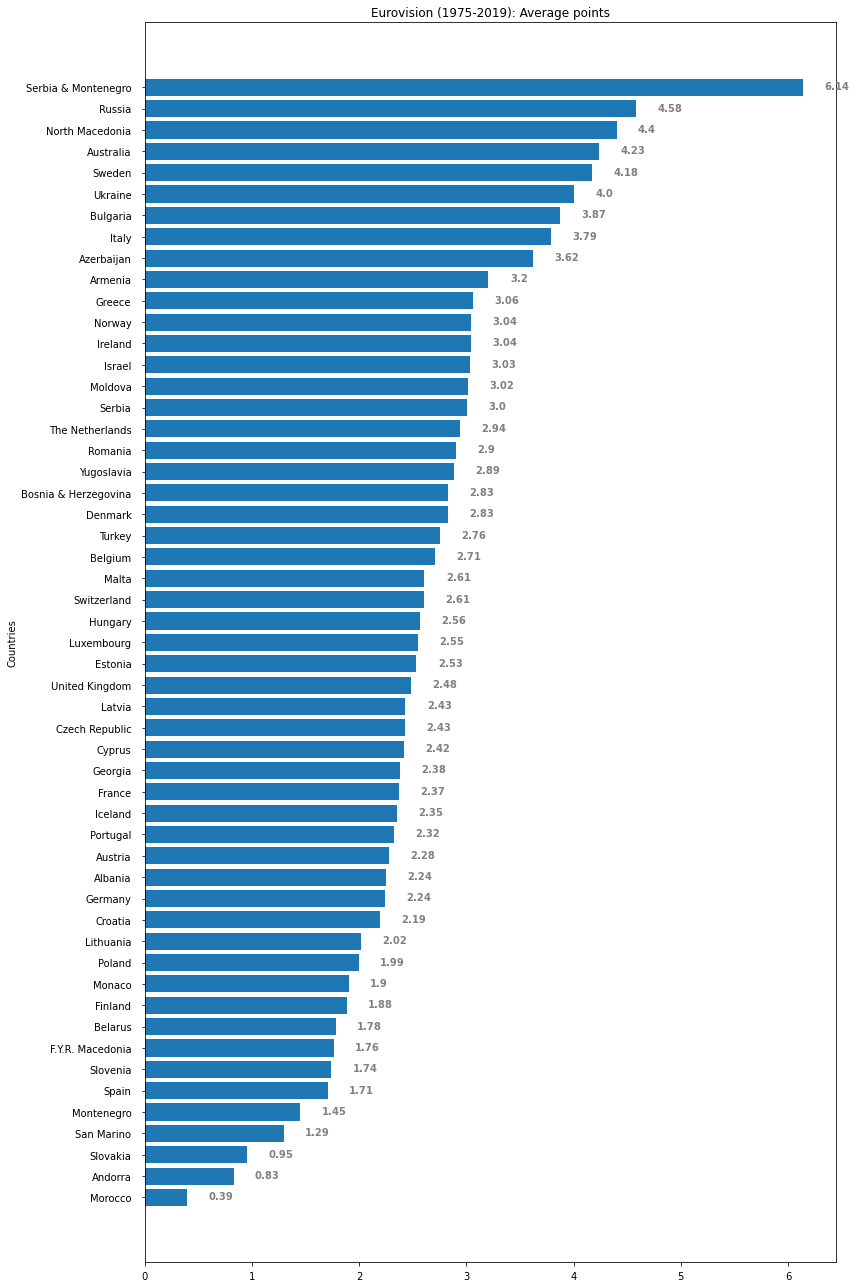

In [19]:
# Plotting average points per country
labels = df_average_points_per_country[('Points', 'mean')].index
avg_points = list(df_average_points_per_country[('Points', 'mean')])

fig, ax = plt.subplots(figsize=(12,18))
rects = ax.barh(labels, avg_points)

ax.invert_yaxis()
ax.set_ylabel('Countries')
ax.set_title('Eurovision (1975-2019): Average points')
ax.xaxis.set_tick_params(pad = 5)
ax.yaxis.set_tick_params(pad = 10)

for i in ax.patches:
    plt.text(i.get_width()+0.2, i.get_y()+0.5,
             str(round((i.get_width()), 2)),
             fontsize = 10, fontweight ='bold',
             color ='grey')
    
fig.tight_layout()
plt.show()

In [20]:
# Average points per Year/Edition
df_average_points_per_country_by_year = df_esc.groupby(['To country', 'Year']).agg({'Points': ['mean']})

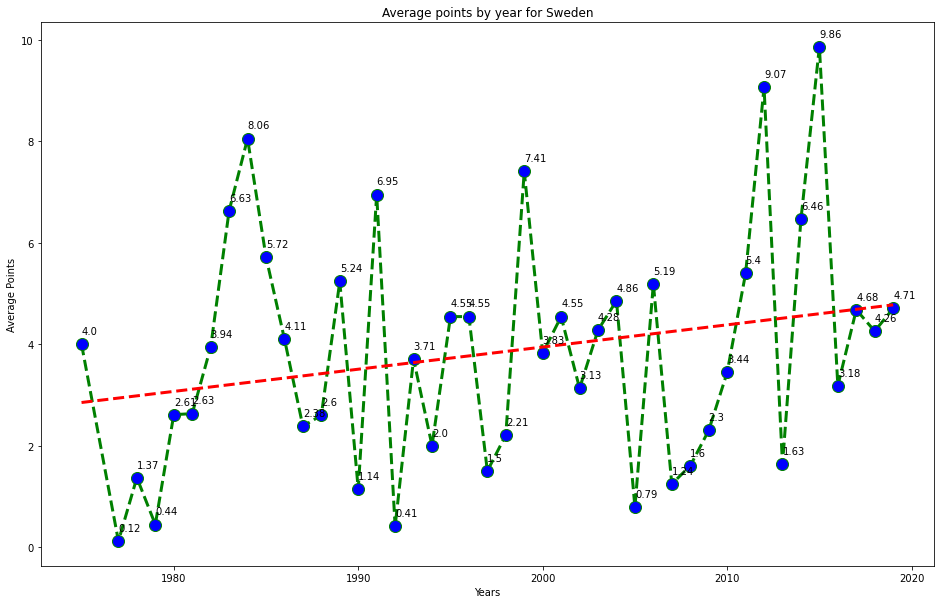

In [21]:
# Evolution of average points for highest scoring country: Sweden
country = 'Sweden'

x = df_average_points_per_country_by_year.loc[[country]].index.get_level_values('Year')
y = df_average_points_per_country_by_year.loc[[country]][('Points', 'mean')]
z = np.poly1d(np.polyfit(x, y, 1))(x)

plt.figure(figsize=(16,10))
plt.plot(x, y, color='green', linestyle='dashed', linewidth = 3, marker='o', markerfacecolor='blue', markersize=12)
plt.plot(x, z,"r--", linewidth = 3)

for year, average_points in zip(x, y): 
    plt.text(year, average_points+0.2, str(round(average_points, 2)))
    
plt.xlabel('Years')
plt.ylabel('Average Points')
plt.title('Average points by year for ' + country)
plt.show()

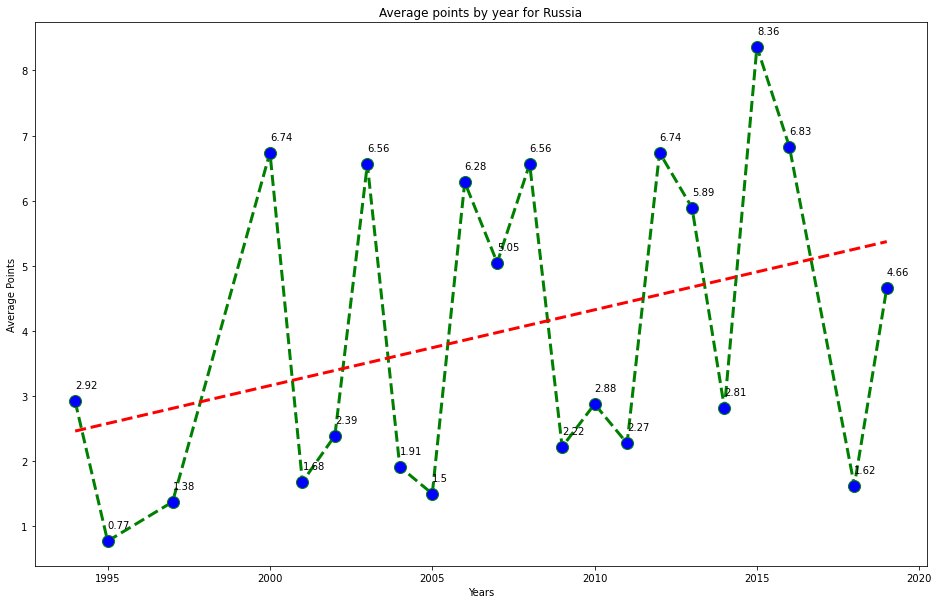

In [22]:
# Second highest scoring country: Russia
country = 'Russia'

x = df_average_points_per_country_by_year.loc[[country]].index.get_level_values('Year')
y = df_average_points_per_country_by_year.loc[[country]][('Points', 'mean')]
z = np.poly1d(np.polyfit(x, y, 1))(x)

plt.figure(figsize=(16,10))
plt.plot(x, y, color='green', linestyle='dashed', linewidth = 3, marker='o', markerfacecolor='blue', markersize=12)
plt.plot(x, z,"r--", linewidth = 3)

for year, average_points in zip(x, y): 
    plt.text(year, average_points+0.2, str(round(average_points, 2)))
    
plt.xlabel('Years')
plt.ylabel('Average Points')
plt.title('Average points by year for ' + country)
plt.show()

In [23]:
# Looking at the ranking of every edition (the total amount of points received per country and the position)
df_rank = df_esc.groupby(['Edition', 'To country']).agg({'Points': ['sum']})
df_rank.columns = ['Total Points']

df_rank['Rank'] = df_rank.groupby(level=0).rank(ascending=False)
df_rank = df_rank.sort_values(['Edition','Rank'], ascending=[True, True])

In [24]:
# The winner and last place for every edition
n_winners_and_losers = 1
winners = df_rank.groupby(level=0).apply(lambda x: x.iloc[:n_winners_and_losers])
losers = df_rank.groupby(level=0).apply(lambda x: x.iloc[-n_winners_and_losers:])

df_winners_and_losers = pd.DataFrame({'Edition': winners.index.get_level_values(0)})
df_winners_and_losers.set_index('Edition', inplace=True)
df_winners_and_losers['Winning country'] = winners.index.get_level_values('To country')
df_winners_and_losers['Winning rank'] = list(winners['Rank'])
df_winners_and_losers['Winning points'] = list(winners['Total Points'])
df_winners_and_losers['Last place country'] = losers.index.get_level_values('To country')
df_winners_and_losers['Last place rank'] = list(losers['Rank'])
df_winners_and_losers['Last place points'] = list(losers['Total Points'])
df_winners_and_losers

,Winning country,Winning rank,Winning points,Last place country,Last place rank,Last place points
Edition,,,,,,
1975f,The Netherlands,1.0,152,Turkey,19.0,3
1976f,United Kingdom,1.0,164,Norway,18.0,7
1977f,France,1.0,136,Sweden,18.0,2
1978f,Israel,1.0,157,Norway,20.0,0
1979f,Israel,1.0,125,Belgium,18.5,5
...,...,...,...,...,...,...
2018sf1,Israel,1.0,283,Iceland,19.0,15
2018sf2,Norway,1.0,266,Georgia,18.0,24
2019f,The Netherlands,1.0,492,United Kingdom,26.0,14


In [25]:
# Entire ranking for every edition (separate for final and semi finals)
df_final_rank = df_rank[~df_rank.index.get_level_values('Edition').str.contains('sf')]
df_final_rank

Total Points  Rank
Edition To country                         
1975f   The Netherlands           152   1.0
        United Kingdom            138   2.0
        Italy                     115   3.0
        France                     91   4.0
        Luxembourg                 84   5.0
...                               ...   ...
2019f   Spain                      58  22.0
        Israel                     46  23.0
        Germany                    32  24.0
        Belarus                    28  25.0
        United Kingdom             14  26.0

[1032 rows x 2 columns]

In [26]:
#Analysis per semi final
df_semifinal = df_esc[df_esc.Year >= df_esc[df_esc['(semi-) final'] == 'sf1']['Year'].unique()[0]]

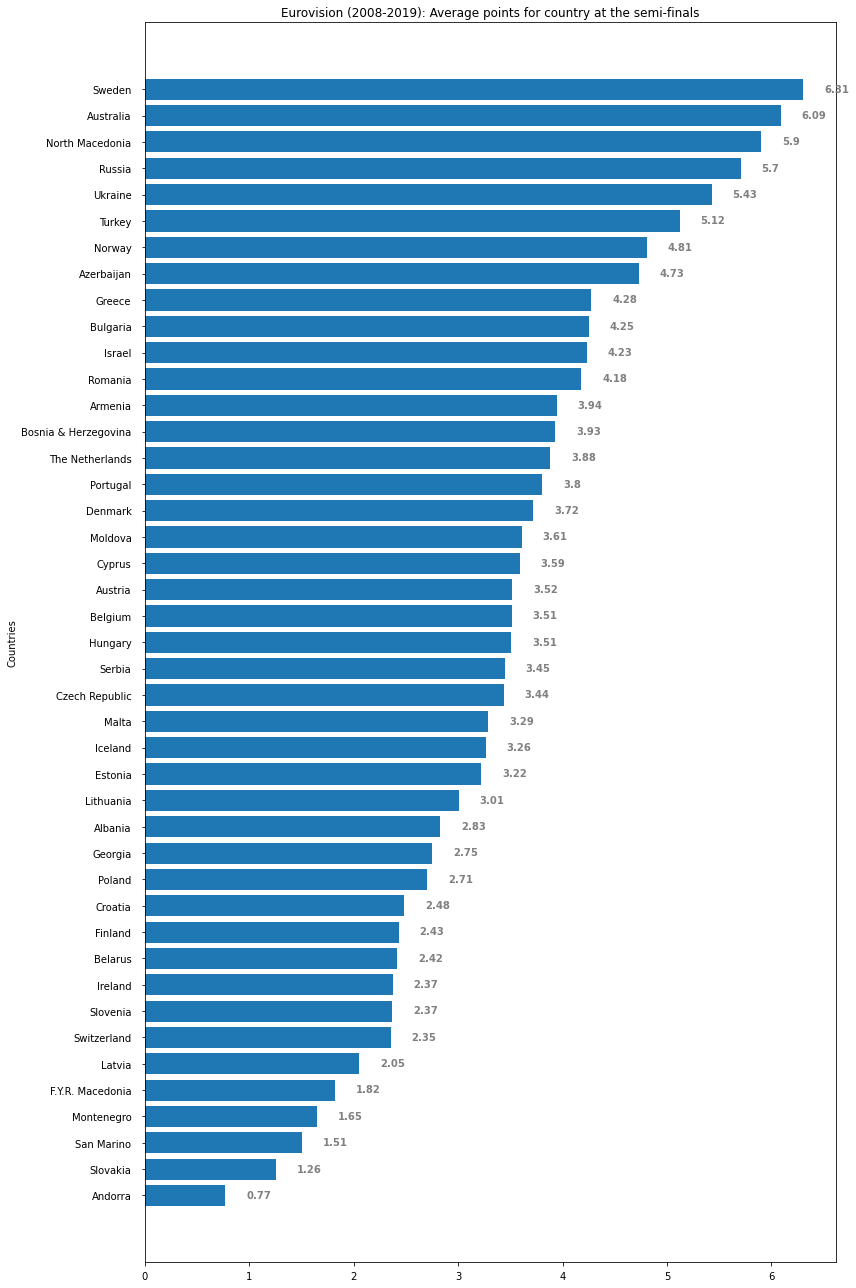

In [27]:
df_average_points_per_country_in_sf = df_semifinal.loc[(df_semifinal['(semi-) final'] == 'sf1') | (df_semifinal['(semi-) final'] == 'sf2')].groupby('To country')['Points'].mean().sort_values(ascending=False).reset_index(name='counts')
labels = df_average_points_per_country_in_sf['To country']
avg_points = list(df_average_points_per_country_in_sf['counts'])

fig, ax = plt.subplots(figsize=(12,18))
rects = ax.barh(labels, avg_points)

ax.invert_yaxis()
ax.set_ylabel('Countries')
ax.set_title('Eurovision (2008-2019): Average points for country at the semi-finals')
ax.xaxis.set_tick_params(pad = 5)
ax.yaxis.set_tick_params(pad = 10)

for i in ax.patches:
    plt.text(i.get_width()+0.2, i.get_y()+0.5,
             str(round((i.get_width()), 2)),
             fontsize = 10, fontweight ='bold',
             color ='grey')
    
fig.tight_layout()
plt.show()

In [28]:
# Average televoting and jury points in semi finals
df_semifinal_jt = df_semifinal.loc[(df_semifinal['(semi-) final'] == 'sf1') | (df_semifinal['(semi-) final'] == 'sf2')].groupby(['To country', 'Jury or Televoting', ])['Points'].mean()

In [29]:
df1 = df_semifinal_jt.iloc[df_semifinal_jt.index.get_level_values('Jury or Televoting') == 'J'].to_frame(name='Jury Points').reset_index(level=1, drop=True)
df2 = df_semifinal_jt.iloc[df_semifinal_jt.index.get_level_values('Jury or Televoting') == 'T'].to_frame(name='Televoting Points').reset_index(level=1, drop=True)

df_average_jt = pd.merge(df1, df2, left_index=True, right_index=True)

df_average_jt['difference between Jury and Televoting points'] = abs(df_average_jt['Jury Points'] - df_average_jt['Televoting Points'])
df_average_jt.sort_values(by='difference between Jury and Televoting points', ascending=False)

,Jury Points,Televoting Points,difference between Jury and Televoting points
To country,,,
North Macedonia,7.750000,4.050000,3.700000
Bulgaria,3.486034,6.491803,3.005770
Portugal,3.284091,6.153846,2.869755
Greece,4.961702,2.262500,2.699202
Malta,3.940426,1.375000,2.565426
Australia,7.303797,4.873418,2.430380
Sweden,6.852792,4.516667,2.336125
Cyprus,2.986301,5.237500,2.251199
Hungary,2.930876,5.101266,2.170390


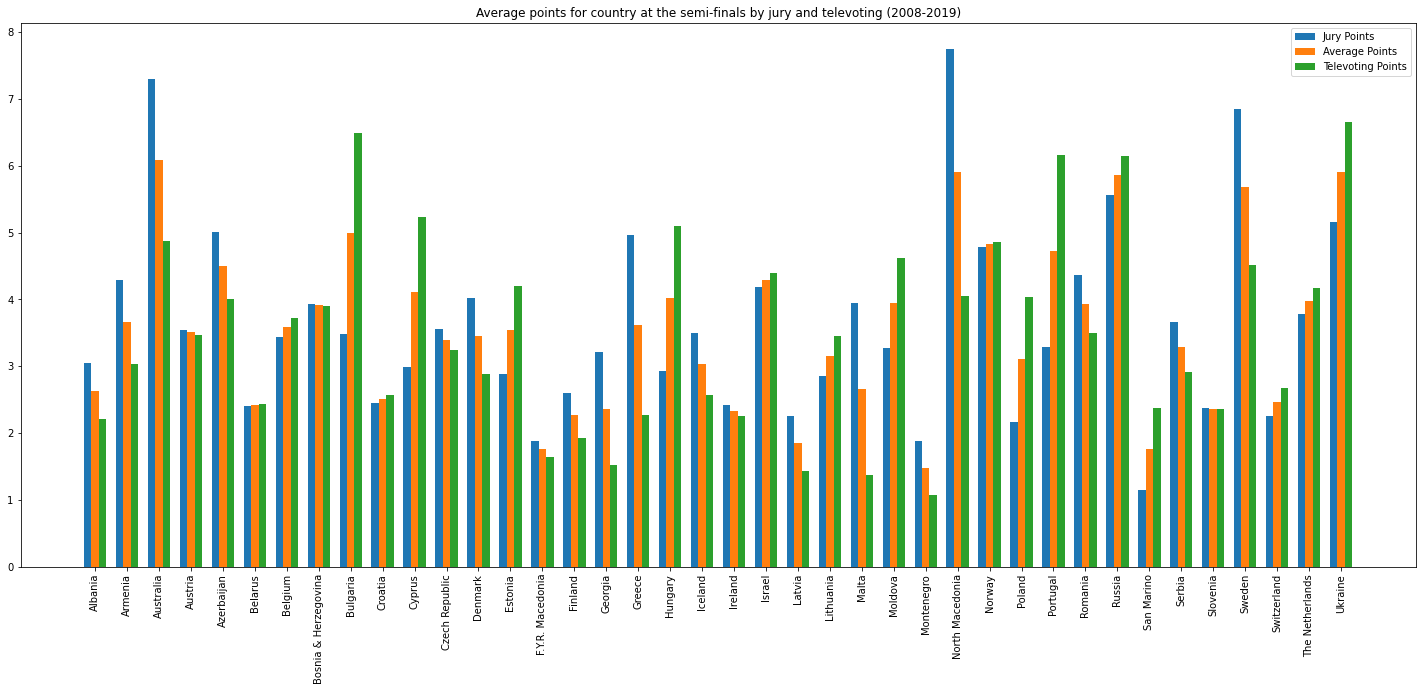

In [30]:
#Plotting the average points from jury and televoting in semi-finals (2008-2019)
plt.figure(figsize=(25,10))

countries = df_average_jt.index
jury_points = df_average_jt['Jury Points']
avg_points = (df_average_jt['Jury Points'] + df_average_jt['Televoting Points']) / 2
televoting_points = df_average_jt['Televoting Points']

def subcategorybar(countries, vals, width=0.8):
    n = len(vals)
    _countries = np.arange(len(countries))
    for i in range(n):
        plt.bar(_countries - width/2. + i/float(n)*width, vals[i], width=width/float(n), align="edge")   
    plt.xticks(_countries, countries, rotation='vertical')
    plt.legend(['Jury Points', 'Average Points', 'Televoting Points'])
    plt.title('Average points for country at the semi-finals by jury and televoting (2008-2019)')
    
subcategorybar(countries, [jury_points, avg_points, televoting_points], 0.7)

plt.show()

In [31]:
# Average points in the final (editions with semi-finals, 2008-2019)
df_average_points_final = df_semifinal[df_semifinal['(semi-) final'] == 'f'].groupby('To country')['Points'].mean().sort_values(ascending=False).reset_index(name='counts')

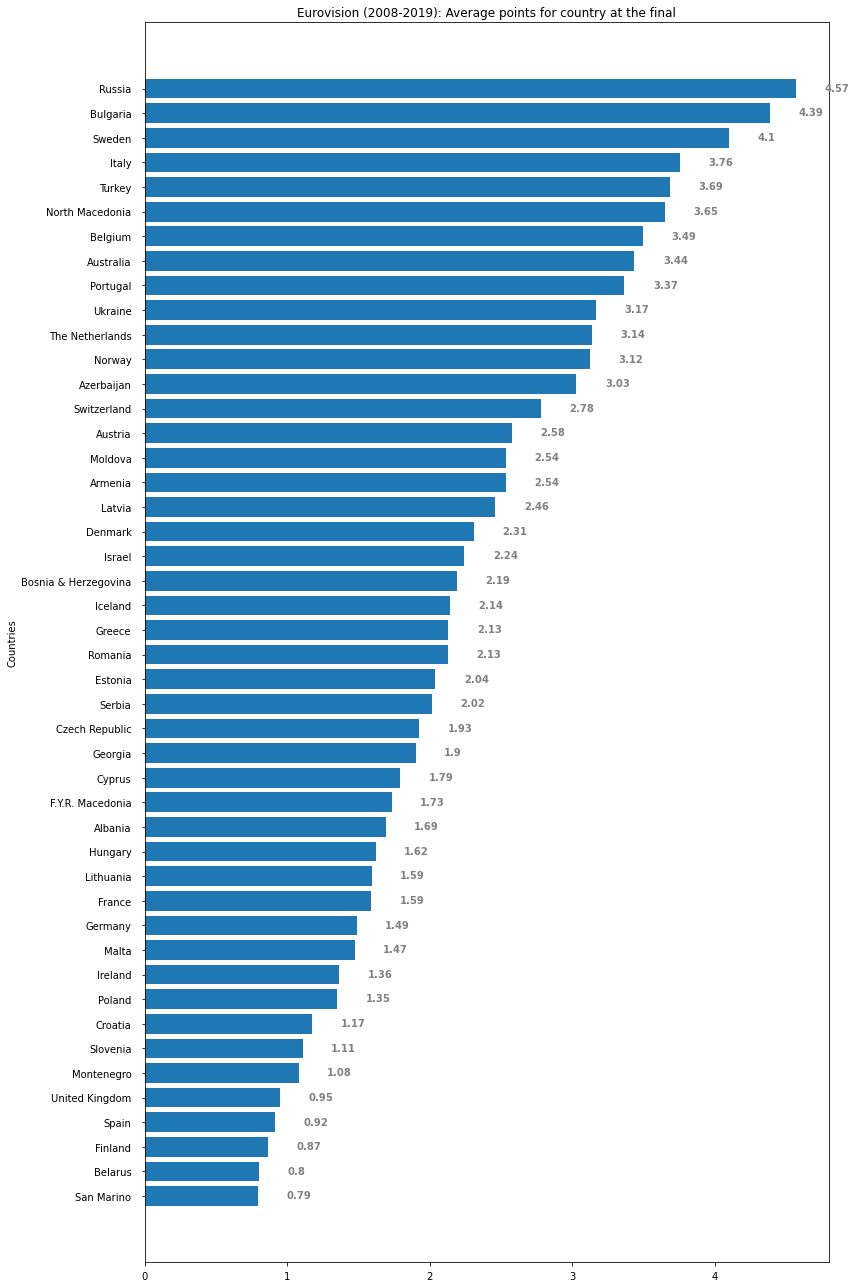

In [32]:
#Plotting average points in finals (2008-2019)
labels = df_average_points_final['To country']
avg_points = list(df_average_points_final['counts'])

fig, ax = plt.subplots(figsize=(12,18))
rects = ax.barh(labels, avg_points)

ax.invert_yaxis()

ax.set_ylabel('Countries')
ax.set_title('Eurovision (2008-2019): Average points for country at the final')
ax.xaxis.set_tick_params(pad = 5)
ax.yaxis.set_tick_params(pad = 10)

for i in ax.patches:
    plt.text(i.get_width()+0.2, i.get_y()+0.5,
             str(round((i.get_width()), 2)),
             fontsize = 10, fontweight ='bold',
             color ='grey')

fig.tight_layout()

plt.show()

In [33]:
df_jt_f = df_semifinal[df_semifinal['(semi-) final'] == 'f'].groupby(['To country', 'Jury or Televoting', ])['Points'].mean()

In [34]:
df1 = df_jt_f.iloc[df_jt_f.index.get_level_values('Jury or Televoting') == 'J'].to_frame(name='Jury Points').reset_index(level=1, drop=True)
df2 = df_jt_f.iloc[df_jt_f.index.get_level_values('Jury or Televoting') == 'T'].to_frame(name='Televoting Points').reset_index(level=1, drop=True)

df_average_jt_f = pd.merge(df1, df2, left_index=True, right_index=True)

df_average_jt_f['difference between Jury and Televoting points'] = abs(df_average_jt_f['Jury Points'] - df_average_jt_f['Televoting Points'])
df_average_jt_f.sort_values(by='difference between Jury and Televoting points', ascending=False)

,Jury Points,Televoting Points,difference between Jury and Televoting points
To country,,,
North Macedonia,5.875000,1.425000,4.450000
Romania,1.745810,5.463415,3.717605
Switzerland,1.940678,5.250000,3.309322
Russia,4.030075,7.207317,3.177242
Iceland,1.833333,4.575000,2.741667
Moldova,1.939929,4.566265,2.626336
Poland,0.582915,3.207317,2.624403
Australia,4.586207,2.012195,2.574012
Sweden,4.769752,2.304878,2.464874


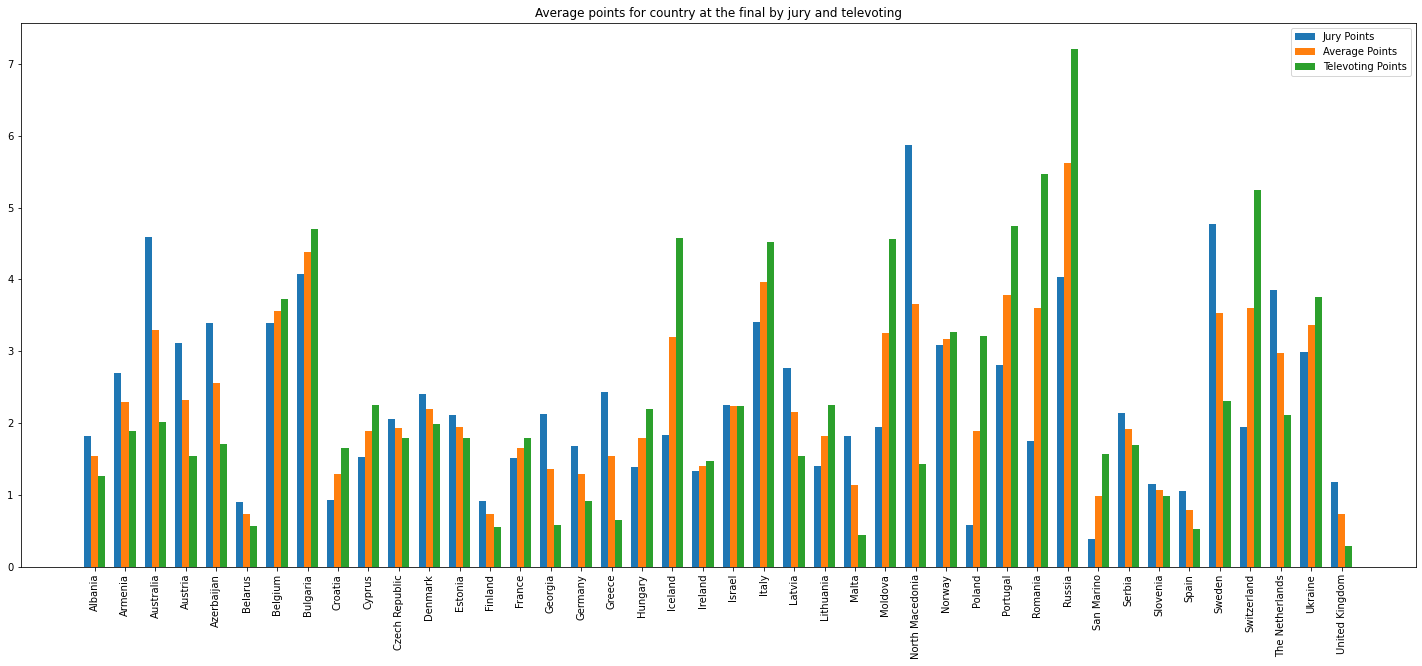

In [35]:
#Plotting average points by jury and televoting final (2008-2019)
plt.figure(figsize=(25,10))

countries = df_average_jt_f.index
jury_points = df_average_jt_f['Jury Points']
avg_points = (df_average_jt_f['Jury Points'] + df_average_jt_f['Televoting Points']) / 2
televoting_points = df_average_jt_f['Televoting Points']

def subcategorybar(countries, vals, width=0.8):
    n = len(vals)
    _countries = np.arange(len(countries))
    for i in range(n):
        plt.bar(_countries - width/2. + i/float(n)*width, vals[i], width=width/float(n), align="edge")   
    plt.xticks(_countries, countries, rotation='vertical')
    plt.legend(['Jury Points', 'Average Points', 'Televoting Points'])
    plt.title('Average points for country at the final by jury and televoting')
    
subcategorybar(countries, [jury_points, avg_points, televoting_points], 0.7)

plt.show()

# rest code ?

In [6]:
# Connect to neo4j database
f=open("authentication/neo4j.txt","r")
lines=f.readlines()
user=lines[0].replace('\n','')
pwd=lines[1].replace('\n','')
http_port = lines[2]
f.close()

graph = Graph(http_port, auth=(user, pwd))

In [7]:
# laod data in neo4j database
# //Eurovision votes in the 2012,2013, 2014 and 2015 final session. (data already included in esc_1975_2019 data set? )
fp = urllib.urlopen("https://goz39a.s3.eu-central-1.amazonaws.com/eurovision/eurovision.txt")
mybytes = fp.read()
data = mybytes.decode("utf8")
fp.close()
graph.run(data)
graph.run("MATCH (n) RETURN count(*)")

count(*)
46


In [6]:

def clear_graph(): 
    return (graph.run("MATCH (n)-[r]->() DELETE r"), graph.run("MATCH (n) DELETE n"))
    
clear_graph()

((No data), (No data))